In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as sio
from sklearn.model_selection import train_test_split
from scipy.signal import butter, filtfilt, iirnotch,welch
from scipy.stats import kurtosis, skew
import pywt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb


In [2]:
volunteers = ["1", "2", "3", "4", "5", "6"]
labels = ["A", "B"]
stimuli = ['1', '5', '10', '15', '20', '25', '30']
electrodes = ['FP1', 'FP2', 'PG1', 'PG2', 'F7', 'F3', 'F2', 'F4', 'F8', 'C3', 'C2', 'C4', 'P3', 'P4', 'P2', 'T3', 'T4', 'T5', 'T6', 'O1', 'OZ', 'O2','ECG']

In [3]:
import re
import glob

path = 'Dataset\CSV'
csv_files = glob.glob(path + '/*.csv')
sig1Hz = []
sig5Hz = []
sig10Hz = []
sig15Hz = []
sig20Hz = []
sig25Hz = []
sig30Hz = []
for file in csv_files:
    match = re.search(r'V\d+_[AB]_\d+', file)
    if match:
        identifier = match.group(0)

        if '_5' in identifier:
            sig5Hz.append(file)
        elif '_10' in identifier:
            sig10Hz.append(file)
        elif '_15' in identifier:
            sig15Hz.append(file)
        elif '_20' in identifier:
            sig20Hz.append(file)
        elif '_25' in identifier:
            sig25Hz.append(file)
        elif '_30' in identifier:
            sig30Hz.append(file)
        elif '_1' in identifier:
            sig1Hz.append(file)

print(len(sig1Hz), len(sig5Hz), len(sig10Hz),len(sig15Hz),len(sig20Hz),len(sig25Hz),len(sig30Hz))


12 12 12 12 12 12 12


In [4]:
sig1Hz

['Dataset\\CSV\\V1_A_1.csv',
 'Dataset\\CSV\\V1_B_1.csv',
 'Dataset\\CSV\\V2_A_1.csv',
 'Dataset\\CSV\\V2_B_1.csv',
 'Dataset\\CSV\\V3_A_1.csv',
 'Dataset\\CSV\\V3_B_1.csv',
 'Dataset\\CSV\\V4_A_1.csv',
 'Dataset\\CSV\\V4_B_1.csv',
 'Dataset\\CSV\\V5_A_1.csv',
 'Dataset\\CSV\\V5_B_1.csv',
 'Dataset\\CSV\\V6_A_1.csv',
 'Dataset\\CSV\\V6_B_1.csv']

In [5]:
def load_data(files):
    dfs = []
    for file in files:
        df = pd.read_csv(file)
        df = df.drop(columns='ECG')
        df = df.T
        
        target = 1 if "A" in file else 0
        df["target"] = target

        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

# Load the DataFrames for each frequency category
df_sig1Hz = load_data(sig1Hz)
df_sig5Hz = load_data(sig5Hz)
df_sig10Hz = load_data(sig10Hz)
df_sig15Hz = load_data(sig15Hz)
df_sig20Hz = load_data(sig20Hz)
df_sig25Hz = load_data(sig25Hz)
df_sig30Hz = load_data(sig30Hz)

In [6]:
def split_into_epochs(data, epoch_length):
    num_epochs = data.shape[1] // epoch_length
    epochs = np.array_split(data[:, :num_epochs * epoch_length], num_epochs, axis=1)
    return epochs


# Convert df_sig1Hz to a NumPy array
data_array = df_sig1Hz.iloc[:,:-1] .to_numpy()

# Define the epoch length in data points
epoch_length = 4 * 256 

# Split the data into epochs
epochs = split_into_epochs(data_array, epoch_length)

# Print the shape of each epoch
for i, epoch in enumerate(epochs):
    print(f"Epoch {i+1} shape: {epoch.shape}")

Epoch 1 shape: (264, 1024)
Epoch 2 shape: (264, 1024)
Epoch 3 shape: (264, 1024)
Epoch 4 shape: (264, 1024)
Epoch 5 shape: (264, 1024)


In [7]:
df_sig1Hz

,0,1,2,3,4,5,6,7,8,9,...,5111,5112,5113,5114,5115,5116,5117,5118,5119,target
0,-26,-14,3,21,36,47,54,52,43,31,...,19,30,28,26,33,48,67,88,105,1
1,-21,-5,11,29,46,60,71,75,73,64,...,47,56,53,51,58,72,89,104,109,1
2,12,19,23,26,29,32,37,39,36,26,...,31,43,41,35,33,33,35,41,46,1
3,-48,-25,-2,21,40,57,70,76,70,55,...,37,68,84,96,111,125,136,142,139,1
4,-39,-17,8,32,51,64,70,67,57,44,...,-23,-5,4,12,27,47,70,90,107,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,-21,-24,-25,-23,-20,-18,-17,-16,-13,-7,...,-16,-16,-12,-6,3,13,22,29,35,0
260,-22,-24,-21,-17,-14,-13,-15,-17,-17,-13,...,-10,-8,-3,4,11,16,19,19,17,0
261,-8,-19,-24,-27,-29,-31,-34,-36,-33,-23,...,-57,-61,-58,-50,-36,-18,1,19,33,0
262,-20,-25,-26,-24,-23,-24,-25,-27,-25,-18,...,-45,-45,-38,-26,-10,6,21,33,41,0


In [8]:
label_counts = df_sig1Hz['target'].value_counts()
label_counts #132 labels after + 132 labels before = 264 which is 22 channels * 12 subjects

target
1    132
0    132
Name: count, dtype: int64

In [9]:
X = df_sig1Hz.iloc[:,:-1] 
y = df_sig1Hz.iloc[:, -1]
print(X.shape, y.shape)

(264, 5120) (264,)


In [10]:
# Preprocessing functions
def butterworth_filter(data, order, cutoff_freq, fs):
    nyquist_freq = 0.5 * fs
    normal_cutoff = cutoff_freq / nyquist_freq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data, axis=1)
    return filtered_data

def notch_filter(data, notch_freq, q_factor, fs):
    b, a = iirnotch(notch_freq, q_factor, fs=fs)
    filtered_data = filtfilt(b, a, data, axis=1)
    return filtered_data

def extract_time_domain_features(data):
    features = []
    features.append(np.mean(data, axis=1))
    features.append(np.std(data, axis=1))
    features.append(np.min(data, axis=1))
    features.append(np.max(data, axis=1))
    features.append(kurtosis(data, axis=1))
    features.append(skew(data, axis=1))
    return np.column_stack(features)

def extract_frequency_domain_features(data, fs):
    f, psd = welch(data, fs=fs)
    spectral_entropy = -np.sum(psd * np.log2(psd + np.finfo(float).eps), axis=1)
    return np.column_stack((psd, spectral_entropy))

def hjorth_activity(signal):
    return np.var(signal)

def hjorth_mobility(signal):
    return np.sqrt(np.var(np.diff(signal)) / np.var(signal))

def hjorth_complexity(signal):
    return hjorth_mobility(np.diff(signal)) / hjorth_mobility(signal)

def second_diff_mean(signal):
    return np.mean(np.abs(np.diff(np.diff(signal))))

def second_diff_max(signal):
    return np.max(np.abs(np.diff(np.diff(signal))))

def coefficient_of_variation(signal):
    return np.std(signal) / np.mean(signal)

def first_diff_mean(signal):
    return np.mean(np.abs(np.diff(signal)))

def first_diff_max(signal):
    return np.max(np.abs(np.diff(signal)))

def wavelet_transform_features(signal):
    coeffs = pywt.wavedec(signal, 'db4')  
    features = []
    for coeff in coeffs:
        features.append(np.mean(coeff))
        features.append(np.std(coeff))
    return features

def vertex_to_vertex_slope(signal):
    v2v_slope = np.diff(signal)
    return np.var(v2v_slope), np.mean(v2v_slope)

def fft_features(signal):
    fft_values = np.fft.fft(signal)
    power_spectrum = np.abs(fft_values) ** 2
    max_power = np.max(power_spectrum)
    return max_power

def shannon_entropy(signal):
    normalized_signal = signal / np.sum(signal)
    entropy = -np.sum(normalized_signal * np.log2(normalized_signal))
    return entropy

def entropy_spectral(signal):
    fft_values = np.fft.fft(signal)
    power_spectrum = np.abs(fft_values) ** 2
    normalized_spectrum = power_spectrum / np.sum(power_spectrum)
    entropy = -np.sum(normalized_spectrum * np.log2(normalized_spectrum))
    return entropy


In [11]:
def extract_features(X):
    # Apply low-pass filter to X data
    order_lp = 6
    cutoff_freq_lp = 80
    fs = 256
    X_filtered = butterworth_filter(X, order_lp, cutoff_freq_lp, fs)

    # Apply notch filter to X data
    notch_freq = 50
    q_factor = 30
    X_filtered = notch_filter(X_filtered, notch_freq, q_factor, fs)

    # Extract time domain features
    time_features = extract_time_domain_features(X_filtered)

    # Extract frequency domain features
    freq_features = extract_frequency_domain_features(X_filtered, fs)

    hjorth_activity_features = np.apply_along_axis(hjorth_activity, axis=1, arr=X_filtered)
    hjorth_mobility_features = np.apply_along_axis(hjorth_mobility, axis=1, arr=X_filtered)
    hjorth_complexity_features = np.apply_along_axis(hjorth_complexity, axis=1, arr=X_filtered)
    second_diff_mean_features = np.apply_along_axis(second_diff_mean, axis=1, arr=X_filtered)
    second_diff_max_features = np.apply_along_axis(second_diff_max, axis=1, arr=X_filtered)
    coefficient_of_variation_features = np.apply_along_axis(coefficient_of_variation, axis=1, arr=X_filtered)
    first_diff_mean_features = np.apply_along_axis(first_diff_mean, axis=1, arr=X_filtered)
    first_diff_max_features = np.apply_along_axis(first_diff_max, axis=1, arr=X_filtered)
    wavelet_transformed_features = np.apply_along_axis(wavelet_transform_features, axis=1, arr=X_filtered)
    vertex_to_vertex_slope_features = np.apply_along_axis(vertex_to_vertex_slope, axis=1, arr=X_filtered)
    shannon_entropy_features = np.apply_along_axis(shannon_entropy, axis=1, arr=X_filtered)
    entropy_spectral_features = np.apply_along_axis(entropy_spectral, axis=1, arr=X_filtered)
    fft_features_result = np.apply_along_axis(fft_features, axis=1, arr=X_filtered)

    # Combine all features
    features = np.concatenate(
        (time_features, freq_features, hjorth_activity_features[:, None], hjorth_mobility_features[:, None],
         hjorth_complexity_features[:, None], second_diff_mean_features[:, None], second_diff_max_features[:, None],
         coefficient_of_variation_features[:, None], first_diff_mean_features[:, None], first_diff_max_features[:, None],
         wavelet_transformed_features, vertex_to_vertex_slope_features, 
         shannon_entropy_features[:, None], entropy_spectral_features[:, None], fft_features_result[:, None]),
        axis=1
    )

    features = np.nan_to_num(features, nan=0.0)

    for i in range(features.shape[1]):
        column_values = features[:, i]
        mean = np.mean(column_values)
        std_dev = np.std(column_values)
        
        if std_dev != 0:  # Avoid division by zero
            features[:, i] = (column_values - mean) / std_dev
        else:
            features[:, i] = 0.0  # Set all values to zero if std_dev is zero
        
    return features

In [12]:
def svm_classification(X_train, y_train, X_test, y_test):
    # Create SVM classifier
    svm_classifier = SVC()

    # Train the SVM classifier
    svm_classifier.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = svm_classifier.predict(X_test)

    # Calculate test accuracy
    test_accuracy = accuracy_score(y_test, y_pred) * 100
    print("SVM Accuracy:", test_accuracy)
    print()
    return test_accuracy

In [13]:
def knn_classification(X_train, y_train, X_test, y_test):   
    # Create KNN classifier
    knn_classifier = KNeighborsClassifier()

    # Define hyperparameters to tune
    param_grid = {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(knn_classifier, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    # Get the best hyperparameters
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)

    # Train the KNN classifier with the best hyperparameters
    knn_classifier = KNeighborsClassifier(**best_params)
    knn_classifier.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = knn_classifier.predict(X_test)

    # Calculate test accuracy
    test_accuracy = accuracy_score(y_test, y_pred) * 100
    print("KNN Accuracy:", test_accuracy)


In [14]:
def mlp_classification(X_train, y_train, X_test, y_test):
    # Create MLP classifier
    mlp_classifier = MLPClassifier(max_iter=500)

    # Define hyperparameters to tune
    param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    }

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(mlp_classifier, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    # Get the best hyperparameters
    best_params = grid_search.best_params_
    print()
    print("Best Hyperparameters:", best_params)

    # Train the MLP classifier with the best hyperparameters
    mlp_classifier = MLPClassifier(**best_params)
    mlp_classifier.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = mlp_classifier.predict(X_test)

    # Calculate test accuracy
    test_accuracy = accuracy_score(y_test, y_pred) * 100
    print("MLP Accuracy:", test_accuracy)
    return test_accuracy

In [15]:
def gradient_boosting_classification(X_train, y_train, X_test, y_test):
    # Create DMatrix for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Set hyperparameters for Gradient Boosting
    params = {
        'objective': 'multi:softmax',  # Classification objective
        'num_class': len(np.unique(y_train)),  # Number of classes
        'eval_metric': 'merror'  # Evaluation metric
    }

    # Train the model
    num_rounds = 100  # Number of boosting rounds
    bst = xgb.train(params, dtrain, num_rounds)

    # Make predictions on the test set
    y_pred = bst.predict(dtest)

    # Convert predicted labels to integers
    y_pred = y_pred.astype(int)

    # Calculate test accuracy
    test_accuracy = accuracy_score(y_test, y_pred) * 100
    print("Gradient Boosting Accuracy:", test_accuracy)
    return test_accuracy

In [16]:
def random_forest_classification(X_train, y_train, X_test, y_test):
    # Define the parameter grid for hyperparameter tuning
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5, 10],
        'max_features': ['sqrt', 'log2']
    }

    # Create the Random Forest classifier
    rf_classifier = RandomForestClassifier(random_state=42)

    # Perform hyperparameter tuning using GridSearchCV
    grid_search = GridSearchCV(rf_classifier, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    # Get the best hyperparameters
    best_params = grid_search.best_params_
    print()
    print("Best Hyperparameters:", best_params)

    # Train the Random Forest classifier with the best hyperparameters
    rf_classifier = RandomForestClassifier(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        max_features=best_params['max_features'],
        random_state=42
    )
    rf_classifier.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = rf_classifier.predict(X_test)

    # Calculate test accuracy
    test_accuracy = accuracy_score(y_test, y_pred) * 100
    print("Random Forest Accuracy:", test_accuracy)

    return test_accuracy


In [17]:
X = df_sig1Hz.iloc[:, :-1]
y = df_sig1Hz.iloc[:, -1]
features = extract_features(X.values)
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)
svm_classification(X_train, y_train, X_test, y_test)
knn_classification(X_train, y_train, X_test, y_test)
mlp_classification(X_train, y_train, X_test, y_test)
gradient_boosting_classification(X_train, y_train, X_test, y_test)
random_forest_classification(X_train, y_train, X_test, y_test)

C:\Users\anne_\AppData\Local\Temp\ipykernel_11556\1923949949.py:73: RuntimeWarning: invalid value encountered in log2
  entropy = -np.sum(normalized_signal * np.log2(normalized_signal))


SVM Accuracy: 92.45283018867924

Best Hyperparameters: {'n_neighbors': 5, 'weights': 'uniform'}
KNN Accuracy: 94.33962264150944

Best Hyperparameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}


c:\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP Accuracy: 98.11320754716981
Gradient Boosting Accuracy: 94.33962264150944

Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}
Random Forest Accuracy: 98.11320754716981


98.11320754716981

In [18]:
# Split the data into features and labels
X = df_sig5Hz.iloc[:, :-1]
y = df_sig5Hz.iloc[:, -1]
features = extract_features(X.values)
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)
svm_classification(X_train, y_train, X_test, y_test)
knn_classification(X_train, y_train, X_test, y_test)
mlp_classification(X_train, y_train, X_test, y_test)

C:\Users\anne_\AppData\Local\Temp\ipykernel_11556\1923949949.py:73: RuntimeWarning: invalid value encountered in log2
  entropy = -np.sum(normalized_signal * np.log2(normalized_signal))


SVM Accuracy: 86.79245283018868

Best Hyperparameters: {'n_neighbors': 3, 'weights': 'uniform'}
KNN Accuracy: 98.11320754716981

Best Hyperparameters: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'solver': 'adam'}
MLP Accuracy: 96.22641509433963


c:\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


96.22641509433963

In [19]:
# Split the data into features and labels
X = df_sig10Hz.iloc[:, :-1]
y = df_sig10Hz.iloc[:, -1]
features = extract_features(X.values)
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)
svm_classification(X_train, y_train, X_test, y_test)
knn_classification(X_train, y_train, X_test, y_test)
mlp_classification(X_train, y_train, X_test, y_test)

C:\Users\anne_\AppData\Local\Temp\ipykernel_11556\1923949949.py:73: RuntimeWarning: invalid value encountered in log2
  entropy = -np.sum(normalized_signal * np.log2(normalized_signal))


SVM Accuracy: 94.33962264150944

Best Hyperparameters: {'n_neighbors': 9, 'weights': 'uniform'}
KNN Accuracy: 92.45283018867924


c:\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
c:\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [ ]:
# Split the data into features and labels
X = df_sig15Hz.iloc[:, :-1]
y = df_sig15Hz.iloc[:, -1]
features = extract_features(X.values)
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)
svm_classification(X_train, y_train, X_test, y_test)
knn_classification(X_train, y_train, X_test, y_test)
mlp_classification(X_train, y_train, X_test, y_test)

C:\Users\anne_\AppData\Local\Temp\ipykernel_5176\1529826752.py:81: RuntimeWarning: invalid value encountered in log2
  entropy = -np.sum(normalized_signal * np.log2(normalized_signal))


SVM Accuracy: 90.56603773584906

Best Hyperparameters: {'n_neighbors': 5, 'weights': 'uniform'}
KNN Accuracy: 98.11320754716981

Best Hyperparameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'solver': 'adam'}
MLP Accuracy: 100.0


c:\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


100.0

In [ ]:
# Split the data into features and labels
X = df_sig20Hz.iloc[:, :-1]
y = df_sig20Hz.iloc[:, -1]
features = extract_features(X.values)
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)
svm_classification(X_train, y_train, X_test, y_test)
knn_classification(X_train, y_train, X_test, y_test)
mlp_classification(X_train, y_train, X_test, y_test)

C:\Users\anne_\AppData\Local\Temp\ipykernel_5176\1529826752.py:81: RuntimeWarning: invalid value encountered in log2
  entropy = -np.sum(normalized_signal * np.log2(normalized_signal))


SVM Accuracy: 86.79245283018868

Best Hyperparameters: {'n_neighbors': 3, 'weights': 'uniform'}
KNN Accuracy: 94.33962264150944

Best Hyperparameters: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'solver': 'adam'}
MLP Accuracy: 98.11320754716981


c:\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


98.11320754716981

In [ ]:
# Split the data into features and labels
X = df_sig25Hz.iloc[:, :-1]
y = df_sig25Hz.iloc[:, -1]
features = extract_features(X.values)
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)
svm_classification(X_train, y_train, X_test, y_test)
knn_classification(X_train, y_train, X_test, y_test)
mlp_classification(X_train, y_train, X_test, y_test)

C:\Users\anne_\AppData\Local\Temp\ipykernel_5176\1529826752.py:81: RuntimeWarning: invalid value encountered in log2
  entropy = -np.sum(normalized_signal * np.log2(normalized_signal))


SVM Accuracy: 98.11320754716981

Best Hyperparameters: {'n_neighbors': 3, 'weights': 'uniform'}
KNN Accuracy: 94.33962264150944

Best Hyperparameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'adaptive', 'solver': 'adam'}
MLP Accuracy: 100.0


100.0

In [ ]:
# Split the data into features and labels
X = df_sig30Hz.iloc[:, :-1]
y = df_sig30Hz.iloc[:, -1]
features = extract_features(X.values)
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)
svm_classification(X_train, y_train, X_test, y_test)
knn_classification(X_train, y_train, X_test, y_test)
mlp_classification(X_train, y_train, X_test, y_test)

C:\Users\anne_\AppData\Local\Temp\ipykernel_5176\1529826752.py:81: RuntimeWarning: invalid value encountered in log2
  entropy = -np.sum(normalized_signal * np.log2(normalized_signal))


SVM Accuracy: 92.45283018867924

Best Hyperparameters: {'n_neighbors': 5, 'weights': 'distance'}
KNN Accuracy: 98.11320754716981

Best Hyperparameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'adaptive', 'solver': 'adam'}
MLP Accuracy: 98.11320754716981


98.11320754716981

In [ ]:
from sklearn.decomposition import FastICA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

# Load the data
X = df_sig1Hz.iloc[:, :-1]
y = df_sig1Hz.iloc[:, -1]

# Apply FastICA to your data
ica = FastICA(n_components=5)  # Specify the number of components you want to extract
ica_data = ica.fit_transform(X)
ica_columns = [f'ICA_Component_{i+1}' for i in range(ica_data.shape[1])]
ica_df = pd.DataFrame(ica_data, columns=ica_columns)
ica_df['target'] = y

# Split the transformed data into features (X) and target (y)
X_ica = ica_df.iloc[:, :-1]
y_ica = ica_df.iloc[:, -1]

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X_ica, y_ica, test_size=0.2, random_state=42)

# Create KNN classifier
knn_classifier = KNeighborsClassifier()

# Train the KNN classifier
knn_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn_classifier.predict(X_test)

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_pred) * 100
print("Test Accuracy:", test_accuracy)


c:\Python311\Lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


Test Accuracy: 96.22641509433963


NameError: name 'df' is not defined

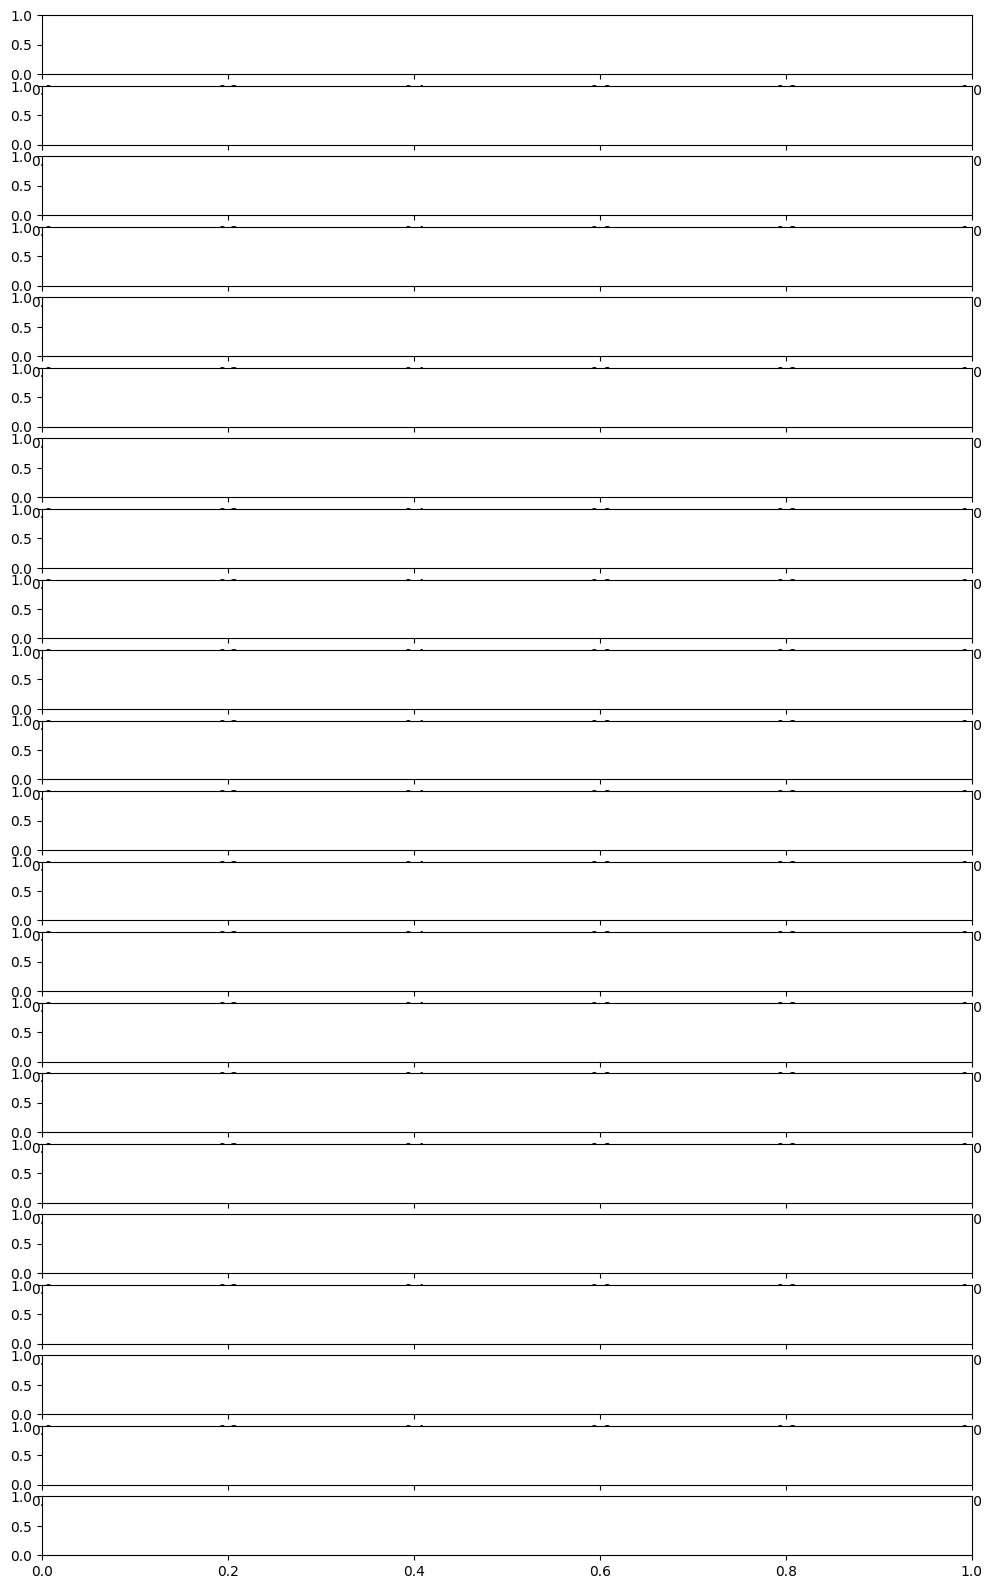

In [ ]:
fig, axes = plt.subplots(22, 1, figsize = (12,20))

for i, ax in enumerate(axes.flatten()):
    y = df.iloc[0:5120,i].values 
    # y = y/1000 #volt y axis
    # plt.ylim(-0.15, 0.3)
    ax.plot(y, color=plt.cm.Paired(i/22.), label=electrodes[i])
    axes[i].set_ylabel('Amplitude')
    # axes[i].set_label(electrodes[i])
    plt.xlabel('Sample points')
    axes[i].legend()

plt.show() 